In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

%matplotlib inline
tf.__version__

'1.1.0'

### Get Housing Data

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


We only take the number of rooms as our feature and the median value as our target

In [3]:
X = df[['RM']].values
y = df['MEDV'].values

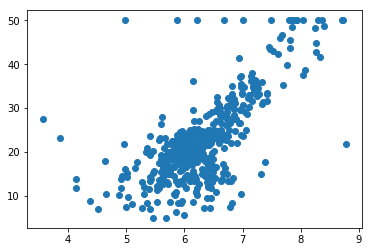

In [4]:
plt.scatter(X, y);

We scale the feature and target which helps with convergence etc.

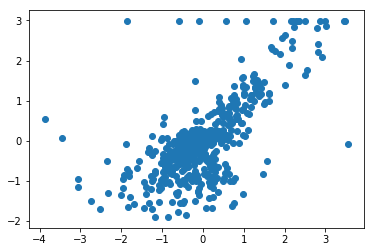

In [5]:
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
plt.scatter(X_std, y_std);

As a check, we run LR through scikit-learn:

In [6]:
from sklearn.linear_model import LinearRegression
X_train = X_std
y_train = y_std
sk_lr = LinearRegression()
sk_lr.fit(X_train, y_train)
loss = np.mean(np.square(y_train - sk_lr.predict(X_train)))
print('Cost\t {:.6f}'.format(loss))
print('w_0\t {:.10f}'.format(sk_lr.intercept_))
print('w_1\t {:.6f}'.format(sk_lr.coef_[0]))

Cost	 0.516475
w_0	 -0.0000000000
w_1	 0.695360


### Tensorflow Version

In [37]:
class LinearRegressionTF(object):

    def __init__(self, eta=0.01, epochs=50, display_step = 10, batch_size=10):
        self.eta = eta
        self.epochs = epochs
        self.display_step_ = display_step
        self.batch_size_ = batch_size
        
    def get_minibatches(self, X):
        return zip(range(0, len(X), self.batch_size_), 
                                      range(self.batch_size_, 
                                      len(X)+1, self.batch_size_))
        
    def train(self, X, y):
        n, m = X.shape
        self.cost_ = []
    
        X_ = tf.placeholder(tf.float32)
        Y_ = tf.placeholder(tf.float32)
        
        W_ = tf.Variable(1., tf.float32, name="weight")
        
        b_ = tf.Variable(0., tf.float32, name="bias")

        output = W_ * tf.transpose(X_) + b_
        
        loss = tf.reduce_mean(tf.square(output - Y_))
        optimizer = tf.train.GradientDescentOptimizer(self.eta)
        train_step = optimizer.minimize(loss)
        
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            
            for i in range(self.epochs):
                X, y = shuffle(X, y)
                
                for start, end in self.get_minibatches(X):
                    sess.run(train_step, feed_dict={
                                                    X_: X[start:end], 
                                                    Y_: y[start:end]
                                                    })
                
                c = sess.run(loss, feed_dict={X_: X, Y_:y})                
                if (i+1) % self.display_step_ == 0:
                    print("Iteration %d | Cost: %f" % (i+1, c))

                self.cost_.append(c)
            
            final_W, final_b, final_loss = sess.run([W_, b_, loss], 
                                                    feed_dict={X_: X, Y_: y})
            self.W = final_W
            self.b = final_b

            print("Training cost=", final_loss, "W=", final_W, "b=", final_b, '\n')

        return self
    
    def predict(self, X):        
        return self.W * X + self.b

In [38]:
X_train = X_std
y_train = y_std

In [45]:
n_iter = 100
eta=0.001

lr_tf = LinearRegressionTF(eta, n_iter, display_step=10, batch_size=10)
lr_tf = lr_tf.train(X_train, y_train)

Iteration 10 | Cost: 0.528805
Iteration 20 | Cost: 0.518207
Iteration 30 | Cost: 0.516778
Iteration 40 | Cost: 0.516548
Iteration 50 | Cost: 0.516478
Iteration 60 | Cost: 0.516495
Iteration 70 | Cost: 0.516480
Iteration 80 | Cost: 0.516478
Iteration 90 | Cost: 0.516475
Iteration 100 | Cost: 0.516475
Training cost= 0.516475 W= 0.694985 b= -0.000166305 



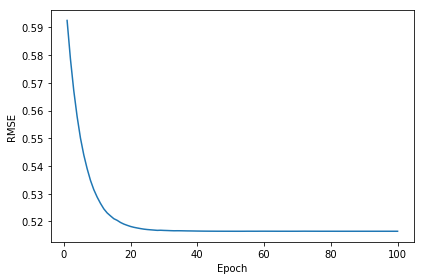

In [46]:
plt.plot(range(1, lr_tf.epochs+1), lr_tf.cost_)
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

In [47]:
from sklearn.metrics import r2_score

In [48]:
y_hat = lr_tf.predict(X_train.astype(np.float32))

In [49]:
r2_score(y_train, y_hat)

0.4835252894386578

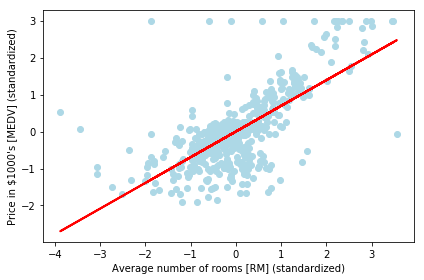

In [50]:
plt.scatter(X_train, y_train, c='lightblue')
plt.plot(X_train, y_hat, color='red', linewidth=2)   
# plt.plot(X_train, y_hat_sk, color='blue', linewidth=2)   
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()
plt.show()